In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install tldextract
!pip install fasttext
# !pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199772 sha256=5faafdbf060b403777c783a017313970a703b997609b6ec447adc5f9b398fe5b
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [2]:
from urllib.parse import urlparse
# import tldextract

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, RobertaForSequenceClassification
# import fasttext
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
import keras
# from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout, Input, Concatenate, LeakyReLU
from keras.regularizers import l1, l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model

import os

In [ ]:
phish_df = pd.read_csv('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/dataset/phishtank_data_corpus_complete_15-07-23.csv')
nonphish_df = pd.read_csv('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/dataset/original_website_dataset.csv')

In [ ]:
phish_df.head()

,id,url,is_valid,phishing_url,submission_time
0,8225238,https://phishtank.org/phish_detail.php?phish_i...,Unknown,https://pocztapolsk.buzz/pay,Jul 15th 2023 9:45 AM
1,8225237,https://phishtank.org/phish_detail.php?phish_i...,VALID PHISH,https://alertsuser.github.io/pantek/kimax/,Jul 15th 2023 9:38 AM
2,8225236,https://phishtank.org/phish_detail.php?phish_i...,Unknown,https://digicamforums.com,Jul 15th 2023 9:19 AM
3,8225235,https://phishtank.org/phish_detail.php?phish_i...,Unknown,SPAMs://wirelessworldshop.com/,Jul 15th 2023 9:19 AM
4,8225234,https://phishtank.org/phish_detail.php?phish_i...,Unknown,SPAMs://www.wirelessworldshop.com,Jul 15th 2023 9:19 AM


In [ ]:
nonphish_df.head()

,url,Speical_Char,Have_IP,Have_At,URL_length,URL_Depth,redirection,time_get_redirect,port_in_url,use_http,...,unescape,escape,ActiveXObject,fromCharCode,atob,Punny_Code,TLDs,Title,country_name,label
0,https://sites.google.com/site/policyclaming76745/,3,0,0,0,2,6,0,0,0,...,0,0,0,0,0,0,com,Google Sites,US,1
1,https://www.pinterest.com/abbiestever/?redirec...,5,0,0,0,1,6,0,0,0,...,0,0,0,0,0,0,com,Abbie Roose Stever (abbiestever) - Profile | P...,NaN,0
2,https://www.pinterest.com/abiolatv/bombshell-g...,3,0,0,1,2,6,0,0,0,...,0,0,0,0,0,0,com,No Title,NaN,0
3,https://balajipackersguntur.com/images/,2,0,0,0,1,6,0,0,0,...,0,0,0,0,0,0,com,Index of /images,IN,1
4,https://sites.google.com/site/claming564336670...,3,0,0,0,2,6,0,0,0,...,0,0,0,0,0,0,com,SECURITY,NaN,1


In [ ]:
phish_df.shape, nonphish_df.shape

((99923, 5), (167872, 32))

### df merge

#### Label

phishing: -1\
genuine: 1

In [ ]:
phish_df['phishing_url']==''

0        False
1        False
2        False
3        False
4        False
         ...  
99918    False
99919    False
99920    False
99921    False
99922    False
Name: phishing_url, Length: 99923, dtype: bool

In [ ]:
df_1 = pd.DataFrame({'url': phish_df['phishing_url'], 'label': -1*np.ones(phish_df.shape[0])})
df_2 = pd.DataFrame({'url': nonphish_df.sample(phish_df.shape[0])['url'], 'label': np.ones(phish_df.shape[0])})

In [ ]:
df = pd.concat([df_1, df_2]).sample(frac=1, ignore_index=True)

In [ ]:
df.head()

,url,label
0,https://magical-faraday.64-226-108-51.plesk.page/,-1.0
1,http://kenh14.vn/xa-hoi/them-mot-lau-dai-phap-...,1.0
2,https://serienjunkies.de,1.0
3,https://vinted-cz.order9420.info,-1.0
4,http://suatendimentosantander.vze.com/,1.0


### data cleaning

In [ ]:
def filter_df(x):
    try:
        scheme = urlparse(str(x))._asdict()['netloc']
        if scheme=='':
            return np.nan
        return x
    except:
        scheme = urlparse(str(x)[:-1])._asdict()['netloc']
        if scheme=='':
            return np.nan
        return x

In [ ]:
df.shape

(199846, 2)

In [ ]:
df['url'] = df['url'].apply(lambda x: filter_df(x))
df.dropna(inplace=True)

In [ ]:
df.shape

(199690, 2)

In [ ]:
urlparse(df['url'][1])._asdict(), urlparse('http://198.50.135.149:80/redirecionamento/tv55lgm.php')._asdict()

({'scheme': 'http',
  'netloc': 'kenh14.vn',
  'path': '/xa-hoi/them-mot-lau-dai-phap-cua-dai-gia-ha-noi-20150508121858684.chn',
  'params': '',
  'query': '',
  'fragment': ''},
 {'scheme': 'http',
  'netloc': '198.50.135.149:80',
  'path': '/redirecionamento/tv55lgm.php',
  'params': '',
  'query': '',
  'fragment': ''})

In [ ]:
def parser(x, key, type):
    try:
        scheme = urlparse(str(x))._asdict()[key]
    except:
        scheme = urlparse(str(x)[:-1])._asdict()[key]

    return pd.Series([scheme], index=[type])


def parse_domain(x):
    subdomain = None
    domain = None
    tld = None
    try:
        scheme = urlparse(str(x))._asdict()['netloc']
        url = tldextract.extract(scheme)
        subdomain, domain, tld = url.subdomain, url.domain, url.suffix
    except:
        scheme = urlparse(str(x)[:-1])._asdict()['netloc']
        url = tldextract.extract(scheme)
        subdomain, domain, tld = url.subdomain, url.domain, url.suffix

    return pd.Series([subdomain, domain, tld], index=['subdomain', 'domain', 'tld'])

In [ ]:
df_protocol = df['url'].apply(lambda x: parser(x, 'scheme', 'protocol'))
df_domain = df['url'].apply(lambda x: parse_domain(x))
df_path = df['url'].apply(lambda x: parser(x, 'path', 'path'))
df_url_length = df['url'].apply(lambda x: len(x)).rename('url_length')

In [ ]:
df_domain.head()

,subdomain,domain,tld
0,magical-faraday.64-226-108-51,plesk,page
1,,kenh14,vn
2,,serienjunkies,de
3,vinted-cz,order9420,info
4,suatendimentosantander,vze,com


In [ ]:
df_protocol.head()

,protocol
0,https
1,http
2,https
3,https
4,http


In [ ]:
df_path.head()

,path
0,/
1,/xa-hoi/them-mot-lau-dai-phap-cua-dai-gia-ha-n...
2,
3,
4,/


In [ ]:
df.shape, df_protocol.shape, df_domain.shape, df_path.shape, df_url_length.shape

((199690, 2), (199690, 1), (199690, 3), (199690, 1), (199690,))

In [ ]:
df.head()

,url,label
0,https://magical-faraday.64-226-108-51.plesk.page/,-1.0
1,http://kenh14.vn/xa-hoi/them-mot-lau-dai-phap-...,1.0
2,https://serienjunkies.de,1.0
3,https://vinted-cz.order9420.info,-1.0
4,http://suatendimentosantander.vze.com/,1.0


In [ ]:
filtered_df = pd.concat([df_protocol, df_domain, df_path, df_url_length, df], axis=1)

In [ ]:
filtered_df.head()

,protocol,subdomain,domain,tld,path,url_length,url,label
0,https,magical-faraday.64-226-108-51,plesk,page,/,49,https://magical-faraday.64-226-108-51.plesk.page/,-1.0
1,http,,kenh14,vn,/xa-hoi/them-mot-lau-dai-phap-cua-dai-gia-ha-n...,86,http://kenh14.vn/xa-hoi/them-mot-lau-dai-phap-...,1.0
2,https,,serienjunkies,de,,24,https://serienjunkies.de,1.0
3,https,vinted-cz,order9420,info,,32,https://vinted-cz.order9420.info,-1.0
4,http,suatendimentosantander,vze,com,/,38,http://suatendimentosantander.vze.com/,1.0


In [ ]:
filtered_df['protocol'].value_counts()

https     168588
http       30850
spams        226
spam          21
hxxps          3
ttps           1
-hxxps         1
Name: protocol, dtype: int64

In [ ]:
filtered_df['tld'].value_counts()

com       98505
org       12599
io         6951
net        5810
ru         5170
          ...  
rw            1
com.mo        1
xin           1
com.ni        1
org.pe        1
Name: tld, Length: 939, dtype: int64

In [ ]:
processed_urls = filtered_df[['protocol', 'subdomain', 'domain', 'tld']].apply(' '.join, axis=1)

In [ ]:
processed_url_df = pd.DataFrame({'processed_url': processed_urls, 'url_length': filtered_df['url_length'], 'label': filtered_df['label'] })

In [ ]:
processed_url_df.head()

,processed_url,url_length,label
0,https magical-faraday.64-226-108-51 plesk page,49,-1.0
1,http kenh14 vn,86,1.0
2,https serienjunkies de,24,1.0
3,https vinted-cz order9420 info,32,-1.0
4,http suatendimentosantander vze com,38,1.0


In [ ]:
processed_url_df['label'].value_counts()

 1.0    99923
-1.0    99767
Name: label, dtype: int64

In [ ]:
# 0 -> phishing
# 1 -> non-phishing
processed_url_df['label'].replace(-1, 0, inplace=True)

In [ ]:
processed_url_df['label'].value_counts()

1.0    99923
0.0    99767
Name: label, dtype: int64

In [ ]:
processed_url_df['processed_url'] = processed_url_df['processed_url'].apply(lambda x: x.lower())

In [ ]:
processed_url_df.head()

,processed_url,url_length,label
0,https magical-faraday.64-226-108-51 plesk page,49,0.0
1,http kenh14 vn,86,1.0
2,https serienjunkies de,24,1.0
3,https vinted-cz order9420 info,32,0.0
4,http suatendimentosantander vze com,38,1.0


In [3]:
# processed_url_df.to_csv('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/processed_urls.csv', index=False)
processed_url_df = pd.read_csv('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/processed_urls.csv')

In [4]:
processed_url_df['url_length'] = (processed_url_df['url_length']-processed_url_df['url_length'].min())/(processed_url_df['url_length'].max()-processed_url_df['url_length'].min())

In [5]:
train, test = train_test_split(processed_url_df, test_size=0.3, random_state=42, stratify=processed_url_df['label'])

In [6]:
train.shape, test.shape

((139783, 3), (59907, 3))

In [7]:
train.head()

,processed_url,url_length,label
103726,http ex-mail biz,0.001731,0.0
123352,https express adobe com,0.008158,0.0
118426,https biolase com,0.001731,1.0
16180,https agilityhurdles net,0.011867,1.0
66556,https xn--d1aqfkf xn--p1ai,0.010383,0.0


In [8]:
url_length_train = train['url_length'].values
url_length_test = test['url_length'].values

In [9]:
url_length_train.shape, url_length_test.shape

((139783,), (59907,))

In [42]:
# ft = fasttext.load_model('drive/MyDrive/Semester/MTP/Phishing-Detection/phishing.custom.embedding.150.bin')
# ft = fasttext.load_model('drive/MyDrive/Semester/MTP/Phishing-Detection/phishing.custom.embedding.unsupervised.100.bin')
w2v = Word2Vec.load('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/phishing.word2vec.embedding.100.bin')

In [10]:
# path_to_glove_file = os.path.join(
#     os.path.expanduser("~"), "/content/drive/MyDrive/Semester/MTP/Phishing-Detection/glove.6B.100d.txt"
# )

# embeddings_index = {}
# with open(path_to_glove_file) as f:
#     for line in f:
#         word, coefs = line.split(maxsplit=1)
#         coefs = np.fromstring(coefs, "f", sep=" ")
#         embeddings_index[word] = coefs

In [43]:
w2v.vector_size

100

In [44]:
MAX_SEQUENCE_LENGTH = 4
EMBEDDING_DIM = w2v.vector_size

In [45]:
all_sentences = pd.concat([train, test], axis=0)
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(all_sentences['processed_url'])
sequences = tokenizer.texts_to_sequences(all_sentences['processed_url'])
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')

## creating embedding matrix

In [ ]:
vocab_size = len(word_index) + 1
embedding_matrix = np.random.random((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = None
    try:
        embedding_vector = w2v.wv.get_vector(word)
    except Exception as e:
        print(word, 'not found', e)
    if embedding_vector is not None:
        embedding_matrix[i, :] = embedding_vector

## build model

In [47]:
def build_model():
    sentence_indices = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')

    embeddings = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(sentence_indices)

    X = Bidirectional(LSTM(units = 32, return_sequences = True))(embeddings)   #, dropout=0.05, recurrent_dropout=0.15 , return_sequences = True
    X = Dropout(rate = 0.4)(X)
    X = Bidirectional(LSTM(units = 16))(X)   #, dropout=0.05, recurrent_dropout=0.15 , return_sequences = True
    X = Dropout(rate = 0.2)(X)
    ip2 = Input(shape=(1,), dtype='float32')
    concat = Concatenate()([X, ip2])
    op = Dense(2, activation='relu')(concat)
    op = Dense(1, activation='sigmoid')(op)

    model = Model(inputs=[sentence_indices, ip2], outputs=op)

    return model

In [48]:
tf.random.set_seed(42)

In [49]:
model = build_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 4, 100)               1360430   ['input_5[0][0]']             
                                                          0                                       
                                                                                                  
 bidirectional_4 (Bidirecti  (None, 4, 64)                34048     ['embedding_2[0][0]']         
 onal)                                                                                            
                                                                                            

In [50]:
train_data = data[:train.shape[0]]
test_data = data[train.shape[0]:]
print(train_data.shape, test_data.shape)

(139783, 4) (59907, 4)


In [51]:
train_data

array([[     3,   1717,     42,    120],
       [     1,    174,    194,      2],
       [     1,  28846,      2,      0],
       ...,
       [     1, 104084,      2,      0],
       [     1, 104085,    301,      2],
       [     1,   8050,    242,      0]], dtype=int32)

In [52]:
X_train, Y_train = train_data, train['label'].values
X_test, Y_test = test_data, test['label'].values

In [53]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001, verbose=1)

history = model.fit([X_train, url_length_train], Y_train, batch_size=64, epochs=100, validation_split= 0.1, callbacks=[earlyStopping])

Epoch 1/100
1966/1966 [==============================] - 28s 10ms/step - loss: 0.4782 - accuracy: 0.7951 - val_loss: 0.4202 - val_accuracy: 0.8222
Epoch 2/100
1966/1966 [==============================] - 21s 10ms/step - loss: 0.4067 - accuracy: 0.8249 - val_loss: 0.3929 - val_accuracy: 0.8274
Epoch 3/100
1966/1966 [==============================] - 20s 10ms/step - loss: 0.3869 - accuracy: 0.8338 - val_loss: 0.3802 - val_accuracy: 0.8349
Epoch 4/100
1966/1966 [==============================] - 21s 11ms/step - loss: 0.3746 - accuracy: 0.8373 - val_loss: 0.3683 - val_accuracy: 0.8406
Epoch 5/100
1966/1966 [==============================] - 21s 11ms/step - loss: 0.3657 - accuracy: 0.8411 - val_loss: 0.3611 - val_accuracy: 0.8404
Epoch 6/100
1966/1966 [==============================] - 21s 11ms/step - loss: 0.3593 - accuracy: 0.8442 - val_loss: 0.3532 - val_accuracy: 0.8472
Epoch 7/100
1966/1966 [==============================] - 19s 10ms/step - loss: 0.3537 - accuracy: 0.8469 - val_loss: 0

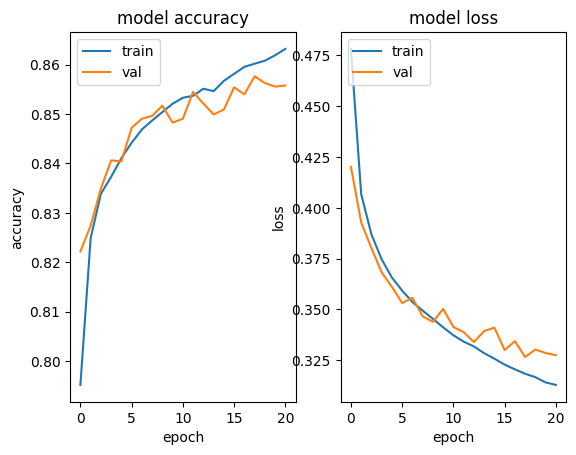

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')

# plt.savefig('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/acc_vs_loss_compariasion.eps', format='eps')
plt.show()

# word2vec output

In [55]:
accr = model.evaluate([X_test, url_length_test], Y_test, batch_size=64)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

937/937 [==============================] - 4s 4ms/step - loss: 0.3178 - accuracy: 0.8622
Test set
  Loss: 0.318
  Accuracy: 0.862


In [56]:
y_pred = model.predict([X_test, url_length_test], batch_size=64, verbose=1)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(classification_report(Y_test, y_pred))

937/937 [==============================] - 6s 5ms/step
              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86     29930
         1.0       0.85      0.89      0.87     29977

    accuracy                           0.86     59907
   macro avg       0.86      0.86      0.86     59907
weighted avg       0.86      0.86      0.86     59907



# glove output

In [28]:
accr = model.evaluate([X_test, url_length_test], Y_test, batch_size=64)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

937/937 [==============================] - 4s 4ms/step - loss: 0.3117 - accuracy: 0.8709
Test set
  Loss: 0.312
  Accuracy: 0.871


In [29]:
y_pred = model.predict([X_test, url_length_test], batch_size=64, verbose=1)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(classification_report(Y_test, y_pred))

937/937 [==============================] - 6s 5ms/step
              precision    recall  f1-score   support

         0.0       0.90      0.83      0.87     29930
         1.0       0.84      0.91      0.88     29977

    accuracy                           0.87     59907
   macro avg       0.87      0.87      0.87     59907
weighted avg       0.87      0.87      0.87     59907

